In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sympy
import datetime

In [2]:
import scipy.fftpack as spfft
from scipy.linalg import hadamard
from sklearn.linear_model import Lasso

In [3]:
import gymnasium

from vizdoom import gymnasium_wrapper  # noqa

In [4]:
def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

alpha=1E-4
max_iter=1E3

In [5]:
def make_noisy(frame, noise):
    if noise == 0.0:
        frame = frame
    else:
        try:
            0.0 <= noise < 1.0
        except ValueError:
            print(f"Value of noise has to be in range [0,1). Got noise={noise}")
        noisemask = np.random.choice(a=[False, True], size=frame.shape, p=[noise, 1.0-noise])
        frame = noisemask * frame
    return frame

In [6]:
def squarify(image):
    org_height, org_width = image.shape
    new_dim = max(org_height, org_width)
    
    delta_h = new_dim - org_height
    delta_w = new_dim - org_width
    
    color = [0, 0, 0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    square_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)

    return square_image

In [7]:
def reconstruct_frame_dct(frame, lasso):
    ny, nx = frame.shape
    A = np.kron(
        spfft.idct(np.identity(nx), norm='ortho', axis=0),
        spfft.idct(np.identity(ny), norm='ortho', axis=0)
        )

    flat_frame = frame.T.reshape(-1,1)
    idx_nonzero = np.where(flat_frame != 0)[0]

    # compressed sample
    b = flat_frame[idx_nonzero]
    # compression matrix @ transform matrix
    Ac = A[idx_nonzero,:]

    # LASSO optimization
    lasso.fit(Ac, b)

    # Reconstruct frame
    Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns

    # Get the reconstructed frame
    Xa = idct2(Xat)

    return Xa

In [8]:
def reconstruct_frame_hadamard(noisyframe, lasso):
    if noisyframe.shape[0] != noisyframe.shape[1]:
        noisyframe = squarify(noisyframe)
        
    ny, nx = noisyframe.shape
    A = hadamard(nx*ny)
    flat_frame = noisyframe.T.reshape(-1,1)
    
    idx_nonzero = np.where(flat_frame != 0)[0]
    
    # compressed sample
    b = flat_frame[idx_nonzero]
    # compression matrix @ transform matrix
    Ac = A[idx_nonzero,:]
    
    # LASSO optimization
    lasso.fit(Ac, b)
    
    # Reconstruct frame
    coeff = np.array(lasso.coef_)
    reconstructed_image = np.array(sympy.fwht(coeff)).astype(np.float32).reshape(width,height).T

    return reconstructed_image

In [9]:
trial_env = gymnasium.make("VizdoomHealthGatheringSupreme-v0", render_mode="rgb_array")
images = []
obss = []

# Rendering random rollouts for ten episodes
for _ in range(2):
    done = False
    obs, info = trial_env.reset(seed=42)
    img = trial_env.render()
    while not done:
        images.append(img)
        obss.append(obs)
        obs, rew, terminated, truncated, info = trial_env.step(trial_env.action_space.sample())
        done = terminated or truncated

/usr/local/lib/python3.10/dist-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:82: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


In [10]:
image = obss[0]["screen"]
bw_image = np.mean(image, -1); # Convert RGB to grayscale

(-0.5, 319.5, 239.5, -0.5)

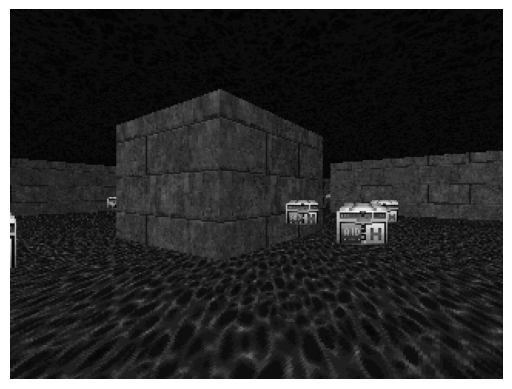

In [11]:
plt.figure()
plt.imshow(bw_image,cmap='gray')
plt.axis('off')

In [12]:
# square_image = squarify(bw_image)
# plt.figure()
# plt.imshow(square_image,cmap='gray')
# plt.axis('off')
square_image = bw_image

In [17]:
square_image.shape

(240, 320)

(-0.5, 127.5, 127.5, -0.5)

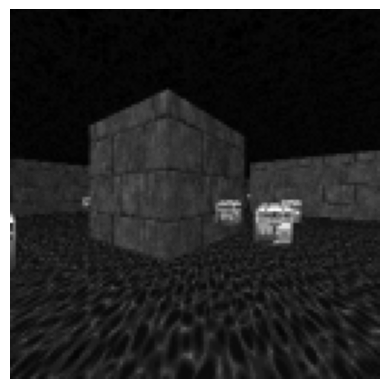

In [13]:
height = 128
width = 128

resized_image = cv2.resize(square_image, (width, height), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(resized_image,cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

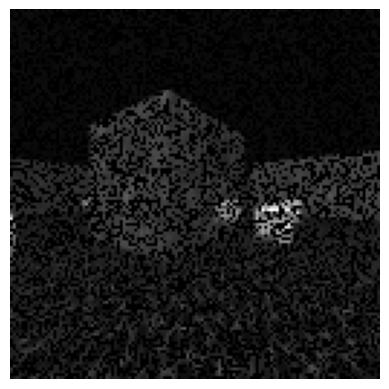

In [14]:
noise = 0.4

noisyframe = make_noisy(resized_image, noise)
plt.figure()
plt.imshow(noisyframe,cmap='gray')
plt.axis('off')

Time elapsed: 0:00:43.319546


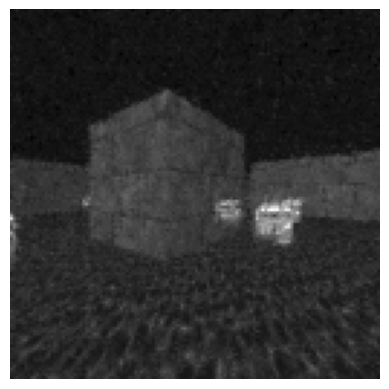

In [15]:
# Reconstruction using DCT
start = datetime.datetime.now()
lasso = Lasso(alpha=alpha, max_iter=int(max_iter), warm_start=True, selection="random")


plt.figure()
plt.imshow(reconstruct_frame_dct(noisyframe, lasso),cmap='gray')
plt.axis('off')
end = datetime.datetime.now()
runtime = end - start
print(f"Time elapsed: {runtime}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.713e+02, tolerance: 4.033e+02
  model = cd_fast.enet_coordinate_descent(


Time elapsed: 0:02:50.094451


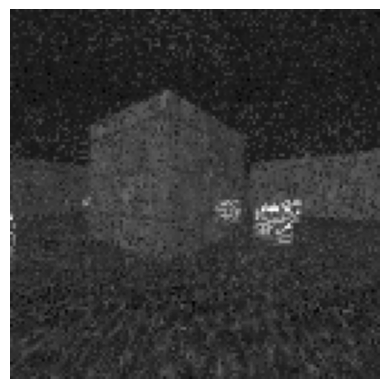

In [16]:
# Reconstruction using Hadamard
start = datetime.datetime.now()
lasso = Lasso(alpha=alpha, max_iter=int(max_iter), warm_start=True, selection="random")

plt.figure()
plt.imshow(reconstruct_frame_hadamard(noisyframe, lasso),cmap='gray')
plt.axis('off')
end = datetime.datetime.now()
runtime = end - start
print(f"Time elapsed: {runtime}")